## 针对生成模型（AutoEncoder）的基于梯度的对抗攻击

### 1、读取CelebA图像

In [1]:
from utils.data_loader import get_loader 
import torch
import torchvision
import torchvision.transforms as transforms

# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

testloader = get_loader("dataset/celeba/images", "dataset/celeba/list.txt", ['Black_Hair'], image_size=256, batch_size=5, mode="test", num_workers=1)

# 3. 获取一批图像和标签
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

Finished preprocessing the CelebA dataset...


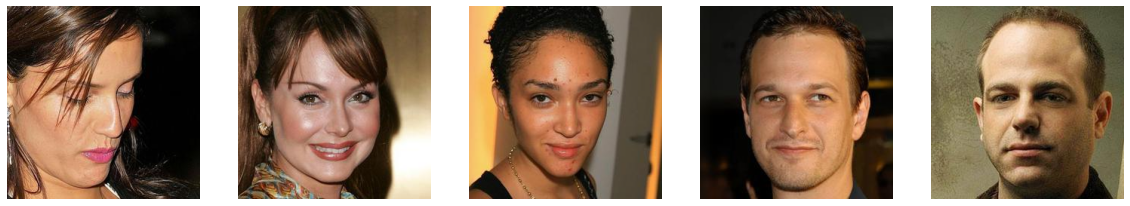

In [2]:
import matplotlib.pyplot as plt
from utils.utils import denorm


# 绘制图像并显示标签
fig, axes = plt.subplots(1, 5, figsize=(20, 10))


# 第一行：显示5张图像
for i in range(5):
    axes[i].imshow(denorm(images)[i].cpu().numpy().transpose((1, 2, 0)))
    axes[i].axis('off')


plt.show()

### 2、用autoencoder对原始图像进行重建

In [3]:
from tarmodel.AutoEncoder import Generator

model = Generator().to(device)
model.load_state_dict(torch.load('checkpoints/AE_celeba.pth'))
model.eval()

Generator(
  (en_layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (en_layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (en_layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (en_layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01

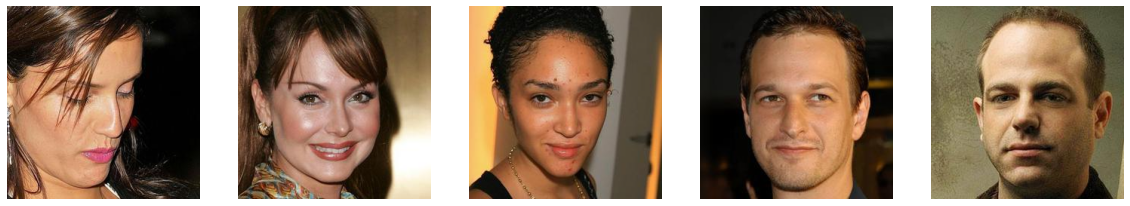

In [4]:
# 1. 获取生成结果
output = model(images.to(device))  # images为输入图像


# 2. 绘制图像并显示预测标签
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    # 将图像从 tensor 转为 numpy 格式，转置为 (H, W, C)
    img = denorm(images)[i].cpu().numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)
    
    # 显示图像
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()

### 3、实施基于梯度的对抗攻击

In [5]:
from utils.attack import LinfPGDAttack4Gen

attack = LinfPGDAttack4Gen(model=model, epsilon=0.05, k=20, device=device)

with torch.no_grad():
        x_real = images
        y = model(images.to(device))
    
adv_images, eta = attack.perturb(images, y)

### 4、可视化对抗样本和攻击结果

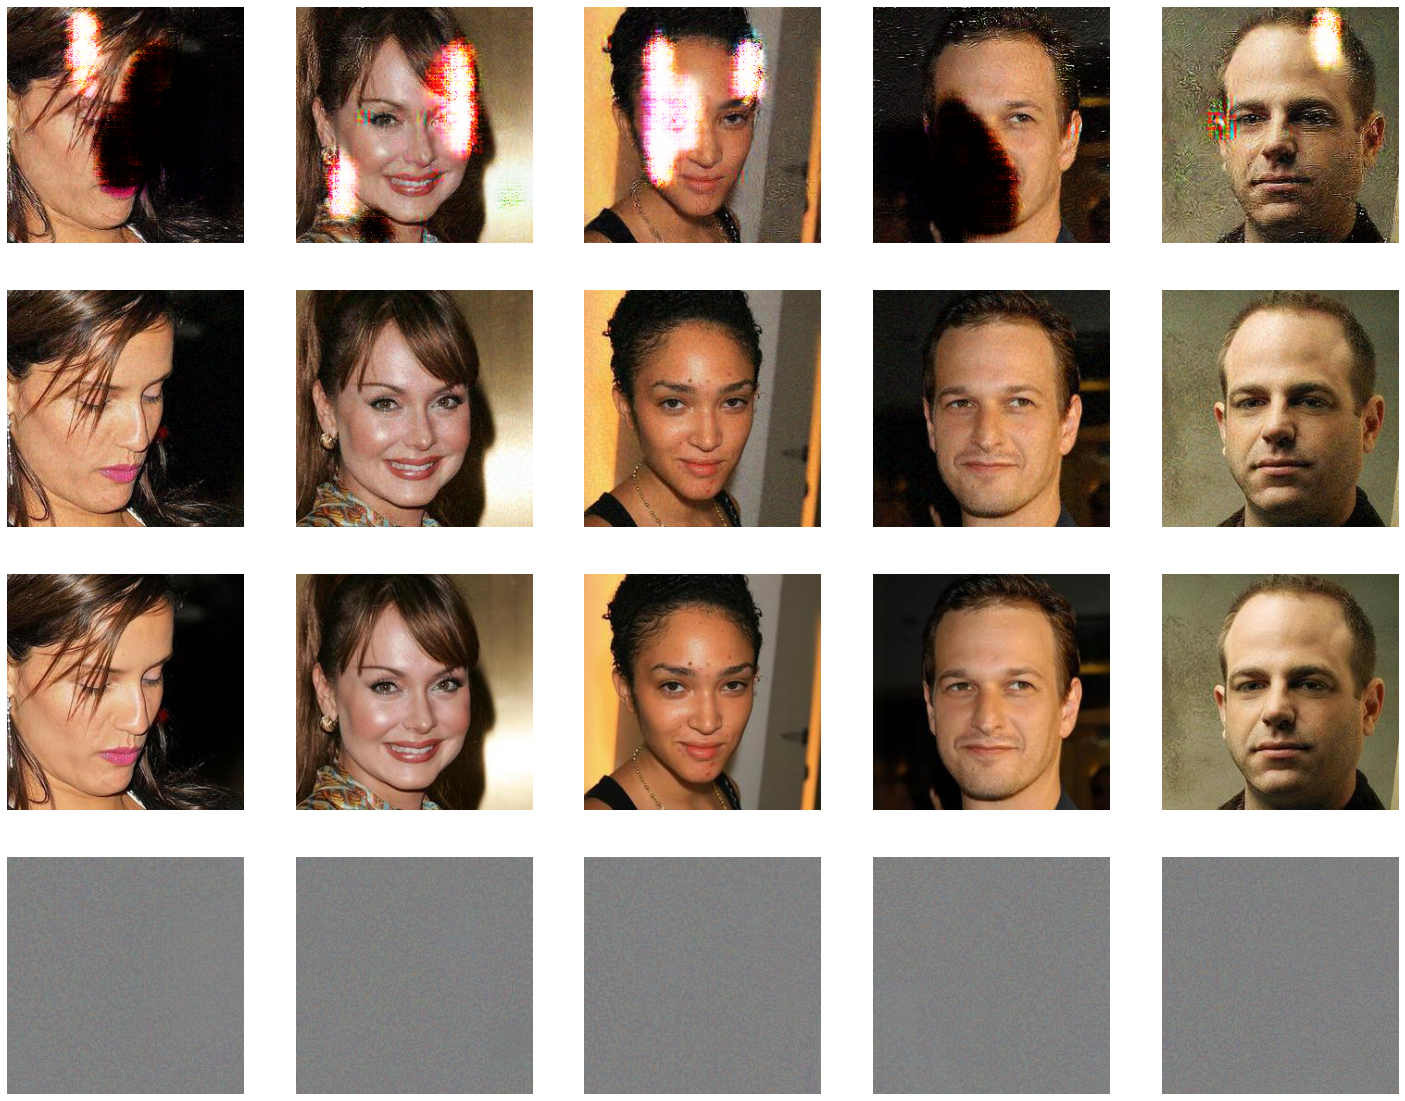

In [6]:
# 获取预测结果
output = model(adv_images.to(device))

# 绘制图像
fig, axes = plt.subplots(4, 5, figsize=(25, 20)) 

for i in range(5):
    # 将图像从 tensor 转为 numpy 格式，转置为 (H, W, C)
    attack_res = denorm(output)[i].detach().cpu().numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)
    adv_img = denorm(adv_images)[i].cpu().numpy().transpose((1, 2, 0))  
    img = denorm(images)[i].cpu().numpy().transpose((1, 2, 0))
    noise = denorm(eta)[i].detach().cpu().numpy().transpose((1, 2, 0))
    

    # 显示攻击结果
    axes[0, i].imshow(attack_res)
    axes[0, i].axis('off')

    # 显示对抗样本
    axes[1, i].imshow(adv_img)
    axes[1, i].axis('off')
    
    # 显示原始图像
    axes[2, i].imshow(img)
    axes[2, i].axis('off')

    # 显示对抗噪声
    axes[3, i].imshow(noise)
    axes[3, i].axis('off')

plt.show()